# Physics-Informed Neural Network (PINN) Model of a DC motor

## Description

This is my attempt to build a data-driven model of a mechatronic system--in this case, a DC motor--using a machine learning model.

## DC Motor's Mathematical Model
The DC Motor is machine with two major subsystems--electrical and mechanical. The mathematical model of both systems are described below

**The electrical equation**
$$v_{DC}(t) = i(t)R + L\dot{i(t)} + \epsilon_a$$
Where $v_{DC}(t)$ is the DC-link voltage, $i(t)$ is the armature current, $\epsilon_a$ is back-emf voltage = $K_b*\omega$ where $K_b$ is the BEMF constant, and $\omega$ is the rotor's speed.
 
 **The Mechanical Equation**
 $$\tau_m - \tau_L = J\dot{\omega} + B\omega$$

Where $\tau_m$ is the motor's electromagnetic torque = $K_ti(t)$,where $K_t$ is the motor's Torque constant. Likewise, $\tau_L$ is the load torque, $J$ is the rotor's inertia, and $B$ is the viscous friction damping coefficient.

These two equations above, then suggests that we could **use two neural networks to help build a complete model of the DC motor. The two neural networks would represent the electrical and mechanical subsystems respectively.**


## What exactly is a PINN?

From my research studies, PINN is just your regular backpropagated neural network, with the exception that the network's loss is not just a function of the error between the actual output and the predicted output; the loss includes the residual losses which are derived your systems dynamic equations[1]. The inclusion of these residuals helps to ensure that any deviation of your network's output from the underlying physical law is penalized[2].


## Why use a PINN?

I have decided to use the physics informed neural network due to the following reasons:

a. It can be used for state estimation (speed and current) as well as parameter estimation (electromechanical parameters like resistance, inertia, etc)[1].

b. It's said to solve differential equations faster, once trained, than your conventional numerical solvers[2].

c. It also has higher accuracy and lesser computational costs compared to the conventional numerical solvers[2].


d. It exploits your system's underlying physical laws and the model is interpretable[1,2].


# Implementation of the PINN

In order to build a PINN model, I have used the resources listed below which also came with links to the repository for the python codes used for their research.

[1] Ayankoso S, Olejnik P. Time-Series Machine Learning Techniques for Modeling and Identification of Mechatronic Systems with Friction: A Review and Real Application. Electronics. 2023; 12(17):3669. https://doi.org/10.3390/electronics12173669
(Link to the research's codes: [here](https://github.com/Samuel-Ayankoso/Neural-Networks-and-ML--Geared-DC-Motor-Case-Study))

[2] G. S. Misyris, A. Venzke and S. Chatzivasileiadis, "Physics-Informed Neural Networks for Power Systems," 2020 IEEE Power & Energy Society General Meeting (PESGM), Montreal, QC, Canada, 2020, pp. 1-5, doi: 10.1109/PESGM41954.2020.9282004.
(Link to the research's code: [here](https://github.com/gmisy/Physics-Informed-Neural-Networks-for-Power-Systems/))

# My methodology

Specificially for the results in this project, I have used mostly the code provided by [1]. In addition, I have made some few adjustments to this code as listed below(the algorithm similar to that of [1] is shown below):

a. Adjusted the design such that the input variables/features are **`time(t), voltage(v), and load torque`($\tau_L$)**. And the outputs are **`rotor shaft's speed`$\omega$** and **`armature current` i**

b. In generating the training data, I tried to not just operate the DC motor in the motoring mode, but in the generating mode as well where the speed drops below zero for a positive torque. This allows the PINN to learn about both modes.

c. I made a simulation of the DC motor using **`collimator.ai`** from which I was able to generate the training and the testing data that I used for building the PINN. In this model, I was able to directly measure the rotor shaft speed and armature current and I also added some noise to both signals. The simulation parameters are shown below:

$$
R = 0.6 #Armature resistance(ohms)
L = 0.035 #Armature inductance(Henry)
K_b = 0.0191 #BEMF constant (V/rad/s)
K_t = 0.0187 #Torque constant(Nm/A)
J = 0.000125 #Rotor's momement of inertia(Kg.m^2)
B = 0.0000095 #Damping coefficient(N.m/(rad/s))
$$

d. I added dropout layers within the PINN's hidden layers to prevent [overfitting](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)

e. I added a function to tune the hyperparameters of the network, such that the best set of hyperparameters that gives the lowest training error is selected as the most optimal.

f. In order to get the hyperparameter tuning to work, the optimizer used by each set of hyperparameters needed to be changed for each iteration. This prevented the use of the **`@tf.function`** decorator. This tensorflow decorator is used to help make the training process faster, but it keeps triggering a ValueError whenever the optimizer needed to be changed per iteration. Unfortunately, this meant that the whole hyperparameter tuning and training process is very slow (It tooks more than 3 hours)


## The PINN algorithm Used in this Script
1. **Import** the neccessary libraries
2. Load the training and test dataset: acquired from simulation
3. Create two neural networks ($N_1$ and $N_2$):
    - Define: input and output dimensions, number of hidden layers, and neurons.
    - Add `J`, `B`, and `K_t` as constrained weights or trainable parameters to $N_1$.
    - Add `R`, `L`, and `K_b` as constrained weights or trainable parameters to $N_2$.
4. Initialize the weights and biases of $N_1$, $N_2$.
5. Tune the hyperparameters
    - Define the hyperparameter search space for both $N_1$ and $N_2$
    - Generate all the hyperparameter combination
    - **For** each combination/set of hyperparameter:
        - Initialize and build the model with the present set of hyperparameters
        - Choose and configure the optimizer
        - Train $N_1$ and $N_2$:
            - for `g` ← 1 to number of epochs (epoch could be a hyperparameter too):
                - Get the predicted training dataset $\hat{\omega} = N_1(t,v,\tau_L)$ and $\hat{I} = N_2(t,v,\tau_L)$
                - Compute the derivative of the two networks: $\frac{d\hat{\omega}}{dt}$ and $\frac{d\hat{I}}{dt}$.
                - Compute the system residuals (physics losses with the losses due to prediction):
                    - $L_1 = \frac{1}{N}\sum^{N-1}_i\left( J\frac{\hat{\omega}(i)}{dt} + B\hat{\omega}(i) + \tau_L(i) - K_t \hat{I}(i)\right)^2$
                    - $L_2 = \frac{1}{N}\sum^{N-1}_i\left( L\frac{d\hat{I}(i)}{dt} + R\hat{I}(i) - v(i) +  K_b \hat{\omega}(i)\right)^2$
                    - $L_3 = \sum^N_i\left(\hat{\omega}(i)- \omega(i)\right)^2$
                    - $L_4 = \sum^N_i\left(\hat{I}(i)- I(i)\right)^2$
                    - $L_{T1} = L_1 + L_3$, $L_{T2} = L_2 + L_4$
                - Compute the losses' gradient $L_{T1}$ and $L_{T2}$ with respect to all the network parameters
                - Update the network parameters(weights, biases and unknown parameters) of $N_1$ and $N_2$
                - Sum the losses of the two networks, $L_{T} = L_{T1} + L_{T2}$
            - end for loop
        -If the total loss $L_{T}$ is the minimum loss:
            - store the loss $L_{T}$ and the hyperparameter set
    -end for loop and return the hyperparameter combination that gives the lowest loss $L_{T}$
6. Train networks $N_1$ and $N_2$ using the optimal hyperparameter set.
    - Follow the training procedures under step 5
7. Test the trained network with the test data and visualize the result
8. Save the two models $N_1$ and $N_2$.


# Import the neccessary modules

In [1]:
# Import Packages
import tensorflow as tf
from tensorflow.keras.constraints import Constraint
from numpy.random import seed
tf.random.set_seed(0)
# setting the seed
seed(0)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time

tf.keras.backend.set_floatx('float64')

%matplotlib widget


# Processing & Visualization of the Training Data 

In [2]:
# Extract the training data
exp_data1 = pd.read_csv('Physics_Model_training.csv')
print(exp_data1.columns)
exp_data1.head(5)

Index(['time', 'Clock_1.out_0', 'Voltage_Steps.out_0',
       'Load_Torque_Steps.out_0', 'Clock_0.out_0', 'DC_Motor.Adder_3.out_0',
       'DC_Motor.Adder_1.out_0', 'DC_Motor.Current', 'DC_Motor.a2.out_0',
       'DC_Motor.Voltage.out_0', 'DC_Motor.a3.out_0', 'DC_Motor.a1.out_0',
       'DC_Motor.Adder_2.out_0', 'DC_Motor.a4.out_0',
       'DC_Motor.x1_current.out_0', 'DC_Motor.Rotor_Shaft_Speed',
       'DC_Motor.random_noise1.PythonScript_0.out_0',
       'DC_Motor.random_noise1.Outport_0',
       'DC_Motor.random_noise1.Clock_0.out_0', 'DC_Motor.b2.out_0',
       'DC_Motor.b1.out_0', 'DC_Motor.Load_torque.out_0',
       'DC_Motor.random_noise2.PythonScript_0.out_0',
       'DC_Motor.random_noise2.Clock_0.out_0',
       'DC_Motor.random_noise2.Outport_0', 'DC_Motor.x2_speed.out_0',
       'DC_Motor.Adder_0.out_0'],
      dtype='object')


,time,Clock_1.out_0,Voltage_Steps.out_0,Load_Torque_Steps.out_0,Clock_0.out_0,DC_Motor.Adder_3.out_0,DC_Motor.Adder_1.out_0,DC_Motor.Current,DC_Motor.a2.out_0,DC_Motor.Voltage.out_0,...,DC_Motor.random_noise1.Outport_0,DC_Motor.random_noise1.Clock_0.out_0,DC_Motor.b2.out_0,DC_Motor.b1.out_0,DC_Motor.Load_torque.out_0,DC_Motor.random_noise2.PythonScript_0.out_0,DC_Motor.random_noise2.Clock_0.out_0,DC_Motor.random_noise2.Outport_0,DC_Motor.x2_speed.out_0,DC_Motor.Adder_0.out_0
0,0.00,0.00,4.0,0.1,0.00,0.425756,-799.850476,0.030254,0.000546,4.0,...,0.424756,0.00,800.0,114.285714,0.1,0.029254,0.00,0.029254,0.001000,114.268026
1,0.01,0.01,4.0,0.1,0.01,-6.580257,-639.336169,1.289434,-3.916686,4.0,...,0.596916,0.01,800.0,114.285714,0.1,0.219124,0.01,0.219124,-7.177174,99.854230
2,0.02,0.02,4.0,0.1,0.02,-9.970788,-499.344156,2.472426,-7.014985,4.0,...,2.883896,0.02,800.0,114.285714,0.1,0.469225,0.02,0.469225,-12.854684,86.960108
3,0.03,0.03,4.0,0.1,0.03,-16.841863,-377.694134,3.193528,-9.400298,4.0,...,0.383815,0.03,800.0,114.285714,0.1,0.379379,0.03,0.379379,-17.225677,75.443456
4,0.04,0.04,4.0,0.1,0.04,-18.537334,-272.411023,3.655929,-11.167246,4.0,...,1.926205,0.04,800.0,114.285714,0.1,0.139660,0.04,0.139660,-20.463539,65.174073


In [3]:
#Get the number of training data
l = exp_data1.shape[0]
print(f'The range/length of the training data is {l}')


#Extract the DC motor's variables of interest, viz, time, voltage, load torque, current, and speed
exp_data_tr = exp_data1[['time','Voltage_Steps.out_0', 'Load_Torque_Steps.out_0','DC_Motor.Rotor_Shaft_Speed', 'DC_Motor.Current']]

#Extract the variables to use as the Neural Network's Input

#a. extract time - t
t = exp_data_tr['time'] #a pandas series
print(t.shape)
t = np.array(t)
t = t.reshape(l,1)
print(t.shape)

#b. extract voltage  - v
v = exp_data_tr['Voltage_Steps.out_0'] #a pandas series
v = np.array(v)
v = v.reshape(l,1)

#c. extract load torque - tau_l
tau_l = exp_data_tr['Load_Torque_Steps.out_0'] #a pandas series
tau_l = np.array(tau_l)
tau_l = tau_l.reshape(l,1)


#Extract the variables to compare with the Neural Network's Output

#a. Extract the speed  - omega
omega = exp_data_tr['DC_Motor.Rotor_Shaft_Speed']
omega = np.array(omega)
omega = omega.reshape(l,1)

#b. Extract the current - i
i = exp_data_tr['DC_Motor.Current']
i = np.array(i)
i = i.reshape(l,1)



The range/length of the training data is 6006
(6006,)
(6006, 1)


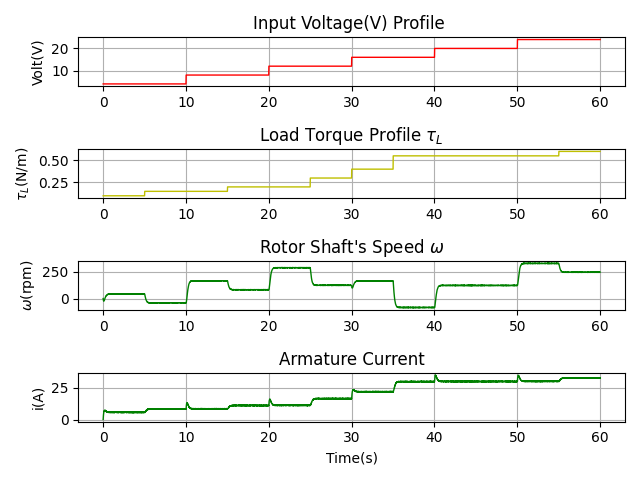

In [4]:
# Create a figure with two subplots
fig, axs = plt.subplots(4, 1)
# Plot the data on the subplots and set the titles
axs[0].plot(t, v, color = 'r', linewidth=1)
axs[0].set_title("Input Voltage(V) Profile ")
axs[0].set_ylabel('Volt(V)')
axs[0].grid(True)

axs[1].plot(t, tau_l,color = 'y', linewidth=1)
axs[1].set_title(r"Load Torque Profile $\tau_L$")
axs[1].set_ylabel(r'$\tau_L$(N/m)')
axs[1].grid(True)

axs[2].plot(t, omega,color = 'g', linewidth=1)
axs[2].set_title("Rotor Shaft's Speed $\omega$")
axs[2].set_ylabel('$\omega$(rpm)')
axs[2].grid(True)

axs[3].plot(t, i,color = 'g', linewidth=1)
axs[3].set_title("Armature Current")
axs[3].set_ylabel('i(A)')
axs[3].set_xlabel('Time(s)')
axs[3].grid(True)


# Adjust the layout of the subplots
fig.tight_layout()
# Show the plots
plt.show()

# Definition of the Classes & Functions for implementing the neural network

In [5]:
# Define model architecture - 
# The Neural Network1 is used to model the DC motor's mechanical system
# Its output is the speed
class Neural_Network1(tf.keras.Model):
    """ Set the basic architecture of the neural network model."""

    def __init__(self,
            output_dimension=1,
            no_of_hidden_layers=3, 
            no_of_neurons_per_layer=32,
            activation1='relu',
            #activation2='linear',
            kernel_initializer='glorot_normal',
            drop_out = 0.02,
            **kwargs):
        super().__init__(**kwargs)

        self.no_of_hidden_layers = no_of_hidden_layers
        self.output_dimension = output_dimension
        
        # Define NN architecture
        self.hidden = [tf.keras.layers.Dense(no_of_neurons_per_layer,
                             activation=tf.keras.activations.get(activation1),
                             kernel_initializer=kernel_initializer) if i%2 == 0 else tf.keras.layers.Dropout(drop_out) for i in range(self.no_of_hidden_layers)]


        self.out = tf.keras.layers.Dense(output_dimension)
        #self.out = tf.keras.layers.Dense(output_dimension,activation=tf.keras.activations.get(activation2))
        
#     def call(self, X):
#         """Forward-pass through neural network."""
#         for i in range(self.no_of_hidden_layers):
#             Z = self.hidden[i](X)
#         return self.out(Z)
    
    def call(self, X):
        """Forward-pass through neural network."""
        Z = X  # Initialize Z with input X
        for i in range(self.no_of_hidden_layers):
            Z = self.hidden[i](Z)  # Pass the output of the previous layer as input to the next layer
        return self.out(Z)  # Output layer

In [6]:
# Define model architecture
# The Neural Network2 is used to model the DC motor's electrical system
# Its output is the current
class Neural_Network2(tf.keras.Model):
    """ Set the basic architecture of the neural network model."""

    def __init__(self,
            output_dimension=1,
            no_of_hidden_layers=3, 
            no_of_neurons_per_layer=32,
            activation1='relu',
            #activation2='linear',
            kernel_initializer='glorot_normal',
            drop_out = 0,
            **kwargs):
        super().__init__(**kwargs)

        self.no_of_hidden_layers = no_of_hidden_layers
        self.output_dimension = output_dimension
        
        # Define NN architecture
        self.hidden = [tf.keras.layers.Dense(no_of_neurons_per_layer,
                             activation=tf.keras.activations.get(activation1),
                             kernel_initializer=kernel_initializer) if i%2 == 0 else tf.keras.layers.Dropout(drop_out) for i in range(self.no_of_hidden_layers)]

        self.out = tf.keras.layers.Dense(output_dimension)
        #self.out = tf.keras.layers.Dense(output_dimension,activation=tf.keras.activations.get(activation2))
        
#     def call(self, X):
#         """Forward-pass through neural network."""
#         for i in range(self.no_of_hidden_layers):
#             Z = self.hidden[i](X)
#         return self.out(Z)
    
    def call(self, X):
        """Forward-pass through neural network."""
        Z = X  # Initialize Z with input X
        for i in range(self.no_of_hidden_layers):
            Z = self.hidden[i](Z)  # Pass the output of the previous layer as input to the next layer
        return self.out(Z)  # Output layer
    

In [7]:
class MinMaxConstraint(Constraint):
    """constrain model weights between [x_min, x_max]."""
    def __init__(self, x_min=0.0, x_max=1.0):
        super().__init__()
        self.x_min = x_min
        self.x_max = x_max
        # TODO: add sanity check if x_max == x_min or w_max == w_min
    
    def __call__(self, w):
        w_min = tf.minimum(tf.math.reduce_min(w), self.x_min)
        w_max = tf.maximum(tf.math.reduce_max(w), self.x_max)
        scale = (self.x_max - self.x_min) / (w_max - w_min)
        m = self.x_min - w_min * scale
        w = w * scale
        return w + m

In [8]:
class Neural_Network1_Param_Identification(Neural_Network1):
    def __init__(self, *args, **kwargs):
        
        # Call init of base class
        super().__init__(*args,**kwargs)
        
        # Initialize the variable that will be identified for the DC motor's mechanical system     
        self.J = tf.Variable(1.0, trainable=True, dtype='float64',constraint=MinMaxConstraint(1e-9, 1))
        self.B = tf.Variable(1.0, trainable=True, dtype='float64',constraint=MinMaxConstraint(1e-9, 1e-6))
        self.K_t = tf.Variable(1.0, trainable=True, dtype='float64',constraint=MinMaxConstraint(1e-3, 1))
        
        self.J_list = []
        self.B_list = []
        self.K_t_list = []

class Neural_Network2_Param_Identification(Neural_Network2):
    def __init__(self, *args, **kwargs):
        
        # Call init of base class
        super().__init__(*args,**kwargs)
        
        # Initialize the variable that will be identified for the DC motor's electrical system
        self.R = tf.Variable(1.0, trainable=True, dtype='float64',constraint=MinMaxConstraint(0.001, 10))
        self.L = tf.Variable(1.0, trainable=True, dtype='float64',constraint=MinMaxConstraint(0.001, 0.1))
        self.K_b = tf.Variable(1.0, trainable=True, dtype='float64',constraint=MinMaxConstraint(1e-3,1))
        
        self.R_list = []
        self.L_list = []
        self.K_b_list = []       
        

In [9]:

def get_derivatives(model1,model2, t,v,tau_l):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(tau_l)
        tape.watch(v)
        tape.watch(t)
        omega_hat= model1(tf.stack([t[:,0], v[:,0], tau_l[:,0]], axis=1))
        i_hat= model2(tf.stack([t[:,0], v[:,0], tau_l[:,0]], axis=1))
        
    omega_hat_dt = tape.gradient(omega_hat,t)
    di_hat_dt = tape.gradient(i_hat,t)
    
    del tape
    return  omega_hat,omega_hat_dt,i_hat,di_hat_dt

# Computing the Model Losses
def compute_all_losses(model1,model2,t,v,tau_l,J,B,K_t,L,R,K_b):
    
    # Compute the reduals of the system equations and the approximate solution losses
    omega_hat, omega_hat_dt,i_hat,di_hat_dt= get_derivatives(model1,model2,t,v,tau_l)
    
    r1_loss = J*omega_hat_dt + B*omega_hat+ tau_l - K_t*i_hat
    r2_loss = L* di_hat_dt  + R*i_hat - v + K_b*omega_hat
       
    loss1  =  tf.reduce_mean(tf.square((r1_loss)))
    loss2  =  tf.reduce_mean(tf.square((r2_loss)))
    
    loss3 = tf.reduce_mean(tf.square(omega_hat-omega))
    loss4 = tf.reduce_mean(tf.square(i_hat-i))
    
    loss_1= loss2+loss4
    loss_2= loss1+loss3
    
    return loss_1, loss_2

In [10]:
def get_gradients(model1,model2,t,v,tau_l,J,B,K_t,L,R,K_b):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with respect to trainable variables      
        tape.watch(model2.trainable_variables)
        tape.watch(model1.trainable_variables)
        loss_1,loss_2 = compute_all_losses(model1,model2,t,v,tau_l,J,B,K_t,L,R,K_b)
        
    g1 = tape.gradient(loss_1, model2.trainable_variables)
    g2 = tape.gradient(loss_2, model1.trainable_variables)
    
    del tape

    return loss_1, loss_2, g1, g2

In [11]:
def train_step(model1,model2,t,v,tau_l,optimizer):
    # Compute current loss and gradient w.r.t. parameters
    loss_1, loss_2, grad_i, grad_omega = get_gradients(model1,model2,t,v,tau_l,model1.J,model1.B,model1.K_t,model2.L,model2.R,model2.K_b)
    
    # Perform gradient descent step
    optimizer.apply_gradients(zip(grad_i, model2.trainable_variables))
    optimizer.apply_gradients(zip(grad_omega, model1.trainable_variables))
    loss_n=loss_1+loss_2
    return loss_n


# Processing of the Testing Data 

In [12]:
#Extracting the Testing Data
exp_data_ts = pd.read_csv('Physics_Model_testing.csv')

#Get the number of training data
l_new = exp_data_ts.shape[0]
print(f'The range/length of the test data is {l}')


#Extract the DC motor's variables of interest, viz, time, voltage, load torque, current, and speed
exp_data_ts = exp_data_ts[['time','Voltage_Steps.out_0', 'Load_Torque_Steps.out_0','DC_Motor.Rotor_Shaft_Speed', 'DC_Motor.Current']]

#Extract the variables to use as the Neural Network's Input

#a. extract time - t
t_new = exp_data_ts['time'] #a pandas series
t_new = np.array(t_new)
t_new = t_new.reshape(l_new,1)

#b. extract voltage  - v
v_new = exp_data_ts['Voltage_Steps.out_0'] #a pandas series
v_new = np.array(v_new)
v_new = v_new.reshape(l_new,1)

#c. extract load torque - tau_l
tau_l_new = exp_data_ts['Load_Torque_Steps.out_0'] #a pandas series
tau_l_new = np.array(tau_l_new)
tau_l_new = tau_l_new.reshape(l_new,1)


#Extract the variables to compare with the Neural Network's Output

#a. Extract the speed  - omega
omega_new = exp_data_ts['DC_Motor.Rotor_Shaft_Speed']
omega_new = np.array(omega_new)
omega_new = omega_new.reshape(l_new,1)

#b. Extract the current - i
i_new = exp_data_ts['DC_Motor.Current']
i_new = np.array(i_new)
i_new = i_new.reshape(l_new,1)

The range/length of the test data is 6006


# Hyperparameter tuning 

Here, I have used a sort of brute force search, which might be similar to a Grid Search

Furthermore, the most optimal set of hyperparameters---that produces the lowest training error--is then used to train the PINN models.

In [13]:
from sklearn.model_selection import ParameterGrid
import random

t = tf.constant(t,  dtype='float64')
v = tf.constant(v,  dtype='float64')
tau_l = tf.constant(tau_l,  dtype='float64')
# optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.01, decay=1e-6)


In [14]:
def hyperparameter_tuning():
    
    # Define hyperparameter search space
    param_grid = {
        'activation1': ['relu'], 
        'activation1_2': ['relu'], 
        'epochs': [4000], 
        'kernel_initializer': ['glorot_normal'], 
        'learning_rate': [0.01], 
          'no_of_hidden_layers': [3], 
          'no_of_hidden_layers2': [4], 
          'no_of_neurons_per_layer': [32,64], 
          'no_of_neurons_per_layer2': [32,64],
        'dropout': [0.001, 0.01,0.1],
        'dropout_2':[0.001,0.01,0.1] 
    }

    # Generate all possible combinations of hyperparameters
    param_combinations = list(ParameterGrid(param_grid))


    print(f'There are {len(param_combinations)} sets of hyperparameters being used for the tuning process\n\n')

    # Training loop for hyperparameter tuning
    
#     Print the hyperparameters
#     for params in param_combinations:
#         print(params)
    
    # set index to track the present set of hyperparameter
    idx = 0

    # Initialize the minimum loss to a very large value
    min_loss = 1e9

    # Buffer to store the computational time for each set of hyperparameter
    comp_time_buff = []
    print('Hyperparameter tuning in progress...\n')
    for params in param_combinations:

        # Initialize model
        model1 = Neural_Network1_Param_Identification(no_of_hidden_layers = params['no_of_hidden_layers'],
                                                     no_of_neurons_per_layer = params['no_of_neurons_per_layer'],
                                                     activation1 = params['activation1'],
                                                     kernel_initializer = params['kernel_initializer'],
                                                     drop_out = params['dropout'])

        model2 = Neural_Network2_Param_Identification(no_of_hidden_layers = params['no_of_hidden_layers2'],
                                                     no_of_neurons_per_layer = params['no_of_neurons_per_layer2'],
                                                     activation1 = params['activation1_2'],
                                                     kernel_initializer = params['kernel_initializer'],
                                                     drop_out = params['dropout_2'])
        #Build the models
        model1.build(input_shape=(None,3))
        model2.build(input_shape=(None,3))

        # Choose and configure the optimizer with a learning rate
        optim = tf.keras.optimizers.legacy.Adam(learning_rate=params['learning_rate'], decay=1e-6)

        # Number of training epochs
        N = params['epochs']

        # Buffer to store the losses for each training epoch
        hist = []

        # Start timer
        t0 = time()


        #train the networks according to the number of epoch in each set of hyperparameters
        for j in range(N+1):
            loss_n = train_step(model1,model2,t,v,tau_l,optim)
            
        #increment the iteration index indicating the index of the hyperparameter
        idx+=1

        # Get the minimum loss and the hyperparameters that gave the minimum loss
        if(loss_n<min_loss):
            min_loss = loss_n
            min_params = params

        # Print computation time for each set of hyperparameter
        comp_time = time()-t0
        comp_time_buff.append(comp_time)

        print('\nComputation time: {}s, hyperparameter-set {}, loss after {} epoch is {}'.format(np.round(comp_time,2),idx,N, np.round(loss_n,4)))
        print()
        
    print('Hyperparameter tuning completed...\n')
    # Print the total time for the hyperparameter tuning process 
    print(f'Total computational time for an hyperparameter tuning of {idx} sets is {np.sum(comp_time_buff)}')
    return min_params, min_loss


In [15]:
# This is used to train the PINN based on the most optimal set of hyperparameters that minimizes the network's losses the most

def train_after_tuning(min_params):

    model1 = Neural_Network1_Param_Identification(no_of_hidden_layers = min_params['no_of_hidden_layers'],
                                                 no_of_neurons_per_layer = min_params['no_of_neurons_per_layer'],
                                                 activation1 = min_params['activation1'],
                                                 kernel_initializer = min_params['kernel_initializer'],
                                                 drop_out = min_params['dropout'])
    model2 = Neural_Network2_Param_Identification(no_of_hidden_layers = min_params['no_of_hidden_layers2'],
                                                 no_of_neurons_per_layer = min_params['no_of_neurons_per_layer2'],
                                                 activation1 = min_params['activation1_2'],
                                                 kernel_initializer = min_params['kernel_initializer'],
                                                 drop_out = min_params['dropout_2'])
    #Build the models
    model1.build(input_shape=(None,3))
    model2.build(input_shape=(None,3))

    # Choose and configure the optimizer with an optimal learning rate
    optim = tf.keras.optimizers.legacy.Adam(learning_rate=min_params['learning_rate'], decay=1e-6)

    # Number of training epochs
    N = min_params['epochs']

    # Buffer to store the losses for each training epoch
    hist = []

    # Start timer
    t0 = time()


    #train the networks according to the optimal number of epoch 
    for j in range(N+1):

        loss_n = train_step(model1,model2,t,v,tau_l,optim)

        # Append current loss--converted from tensorflow to numpy--to hist 
        hist.append(loss_n.numpy())

        J= model1.J.numpy()
    #     model1.J_list.append(J)

        B= model1.B.numpy()
    #     model1.B_list.append(B)

        K_t= model1.K_t.numpy()
    #     model1.K_t_list.append(K_t)

        L= model2.L.numpy()
    #     model2.L_list.append(L)

        R= model2.R.numpy()
    #     model2.R_list.append(R)

        K_b= model2.K_b.numpy()
    #     model2.K_b_list.append(K_b)

    # Print computation time for the epoch in each set of hyperparameter
    comp_time = np.round(time()-t0,2)
    print('\nComputation time: {}s & final training loss {}'.format(comp_time,loss_n))

    # Print the estimated parameters
    print("The identified value of J:",J,",  B:",B, "  K_t:",K_t,"  L:",L,"  R:",R,"  K_b",K_b)


    # Plot the loss versus the number of epochs for each set of hyperparameter
    plt.figure()
    plt.plot(list(range(N+1)),hist)
    plt.xlabel('The number of Epochs')
    plt.ylabel('The training loss')
    plt.title('Epochs Vs Training loss for Optimal Parameters')
    plt.show()
    return model1, model2

In [16]:
#Tune the networks' hyperparameters by calling the tuning function
min_params, min_loss = hyperparameter_tuning()

There are 36 sets of hyperparameters being used for the tuning process


Hyperparameter tuning in progress...


Computation time: 275.08s, hyperparameter-set 1, loss after 4000 epoch is 293.7204


Computation time: 352.57s, hyperparameter-set 2, loss after 4000 epoch is 734.0945


Computation time: 373.11s, hyperparameter-set 3, loss after 4000 epoch is 423.3593


Computation time: 452.5s, hyperparameter-set 4, loss after 4000 epoch is 335.3486


Computation time: 292.53s, hyperparameter-set 5, loss after 4000 epoch is 462.3677


Computation time: 372.5s, hyperparameter-set 6, loss after 4000 epoch is 458.3316


Computation time: 374.57s, hyperparameter-set 7, loss after 4000 epoch is 391.3788


Computation time: 453.76s, hyperparameter-set 8, loss after 4000 epoch is 232.0479


Computation time: 292.4s, hyperparameter-set 9, loss after 4000 epoch is 327.8279


Computation time: 372.34s, hyperparameter-set 10, loss after 4000 epoch is 530.1974


Computation time: 374.79s, hyperparamete

In [17]:
#print the optimal parameter with the lowest loss value
print(f'An optimal hyperparameter is: {min_params}, which gives a total training loss of {np.round(min_loss,4)}')

An optimal hyperparameter is: {'activation1': 'relu', 'activation1_2': 'relu', 'dropout': 0.01, 'dropout_2': 0.01, 'epochs': 4000, 'kernel_initializer': 'glorot_normal', 'learning_rate': 0.01, 'no_of_hidden_layers': 3, 'no_of_hidden_layers2': 4, 'no_of_neurons_per_layer': 64, 'no_of_neurons_per_layer2': 64}, which gives a total training loss of 199.6659



Computation time: 450.16s & final training loss 297.26443962110034
The identified value of J: 8.68233203694722e-05 ,  B: 1e-06   K_t: 0.01846768262172684   L: 0.06605490924905504   R: 0.5978853107107562   K_b 0.018425126948374195


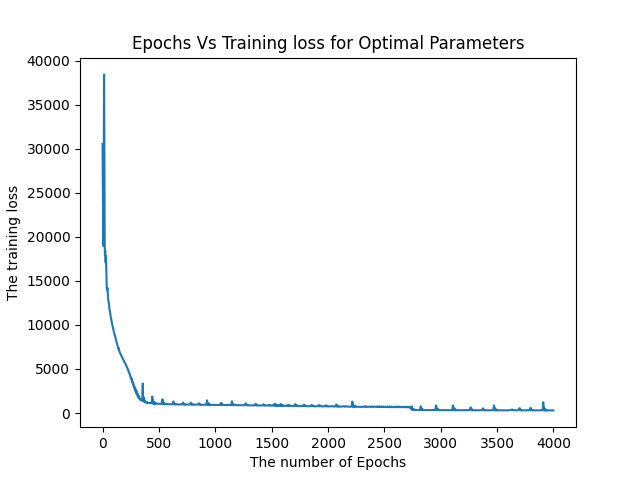

In [18]:
#train the networks using the optimal parameter that minimizes the loss the most
model1,model2 = train_after_tuning(min_params)

# Testing of the PINN models--using the optimal hyperparameters

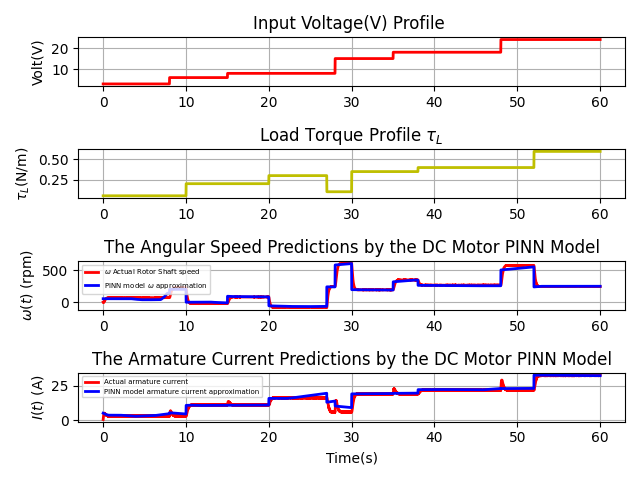

In [19]:
# Prediction with the new (test) data

omega_hat_new= model1(tf.stack([t_new[:,0], v_new[:,0], tau_l_new[:,0]], axis=1)) 
i_hat_new= model2(tf.stack([t_new[:,0], v_new[:,0], tau_l_new[:,0]], axis=1)) 

# Create a figure with two subplots
fig, axs = plt.subplots(4, 1)
# Plot the data on the subplots and set the titles
axs[0].plot(t_new, v_new, color = 'r', linewidth=2)
axs[0].set_title("Input Voltage(V) Profile ")
axs[0].set_ylabel('Volt(V)')
axs[0].grid(True)

axs[1].plot(t_new, tau_l_new,color = 'y', linewidth=2)
axs[1].set_title(r"Load Torque Profile $\tau_L$")
axs[1].set_ylabel(r'$\tau_L$(N/m)')
axs[1].grid(True)

axs[2].plot(t_new, omega_new, color='r',linewidth=2,label=r"$\omega$ Actual Rotor Shaft speed")
axs[2].plot(t_new, omega_hat_new, color='b',linewidth=2,label=r"PINN model $\omega$ approximation")
axs[2].set_title('The Angular Speed Predictions by the DC Motor PINN Model')
axs[2].set_ylabel('$\omega(t)$ (rpm)')
axs[2].legend(loc=2, prop={'size': 5})
axs[2].grid(True)

axs[3].plot(t_new, i_new, color='r',linewidth=2,label="Actual armature current")
axs[3].plot(t_new, i_hat_new, color='b',linewidth=2,label="PINN model armature current approximation")
axs[3].set_title('The Armature Current Predictions by the DC Motor PINN Model')
axs[3].set_ylabel('$I (t)$ (A)')
axs[3].set_xlabel('Time(s)')
axs[3].legend(loc=2, prop={'size': 5})
axs[3].grid(True)

# Adjust the layout of the subplots
fig.tight_layout()
# Show the plots
plt.show()

# Saving the PINN models

I have saved the two models. This way they can be exported to other platforms such as MATLAB/Simulink, Collimator.ai, etc.

In [28]:
#Save the Model
from tensorflow.keras.models import save_model

# Save model1
save_model(model1, '/PINN_Model1/',save_format='tf')

# Save model2
save_model(model2,'PINN_Model2/',save_format='tf')

INFO:tensorflow:Assets written to: C://neural_net_DC//Neural-Networks-and-ML--Geared-DC-Motor-Case-Study/PINN_Model1/assets


INFO:tensorflow:Assets written to: C://neural_net_DC//Neural-Networks-and-ML--Geared-DC-Motor-Case-Study/PINN_Model1/assets


INFO:tensorflow:Assets written to: C://neural_net_DC/Neural-Networks-and-ML--Geared-DC-Motor-Case-Study/PINN_Model2/assets


INFO:tensorflow:Assets written to: C://neural_net_DC/Neural-Networks-and-ML--Geared-DC-Motor-Case-Study/PINN_Model2/assets
